In [27]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

from scipy.optimize import minimize
from scipy.stats import linregress

### Función para expandir el observable

In [28]:
def expand_observable(op, total_qubits):
    expanded_paulis = []
    for pauli, coeff in zip(op.paulis, op.coeffs):
        pauli_str = pauli.to_label()
        # Añadir identidades antes y después según la posición deseada
        new_pauli = (
            pauli_str + "I" * (total_qubits - len(pauli_str))
        )
        expanded_paulis.append((new_pauli, coeff))
    return SparsePauliOp.from_list(expanded_paulis)

### Función para crear el ansatz

c:\Users\juanl\miniconda3\envs\qiskit-tfm\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


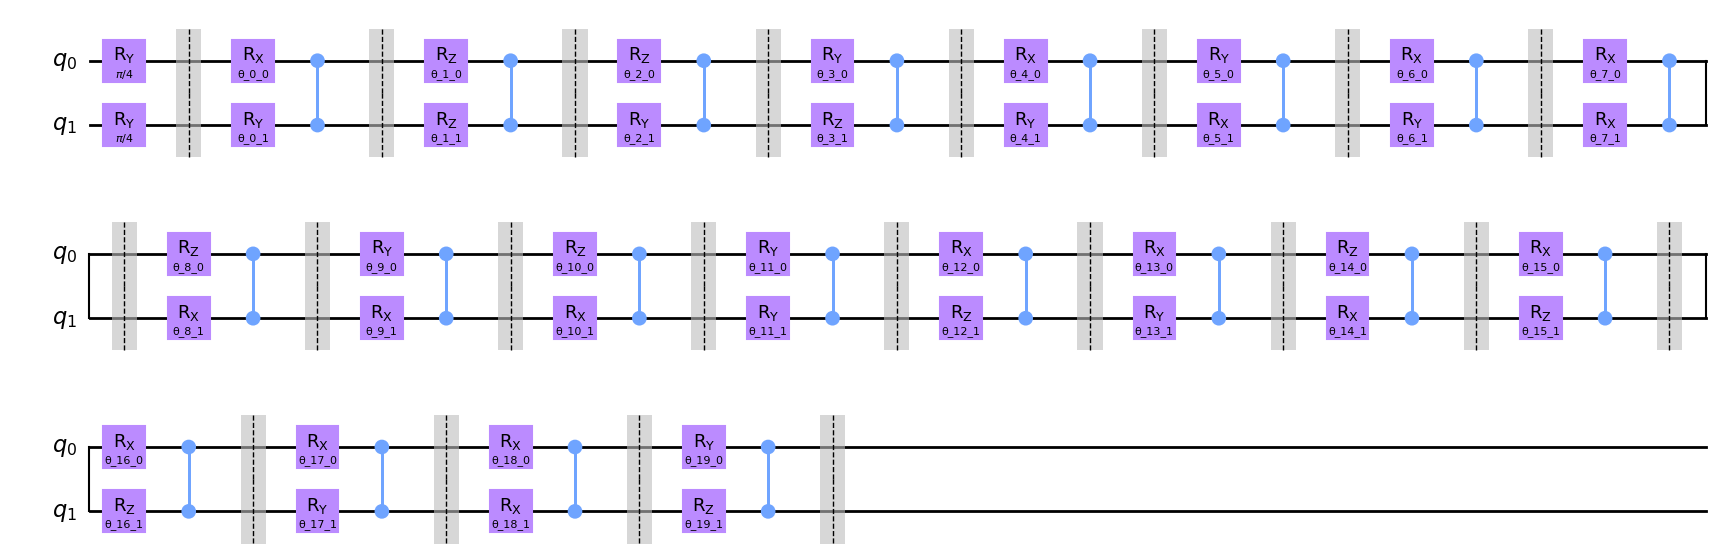

[[Parameter(θ_0_0), Parameter(θ_0_1)], [Parameter(θ_1_0), Parameter(θ_1_1)], [Parameter(θ_2_0), Parameter(θ_2_1)], [Parameter(θ_3_0), Parameter(θ_3_1)], [Parameter(θ_4_0), Parameter(θ_4_1)], [Parameter(θ_5_0), Parameter(θ_5_1)], [Parameter(θ_6_0), Parameter(θ_6_1)], [Parameter(θ_7_0), Parameter(θ_7_1)], [Parameter(θ_8_0), Parameter(θ_8_1)], [Parameter(θ_9_0), Parameter(θ_9_1)], [Parameter(θ_10_0), Parameter(θ_10_1)], [Parameter(θ_11_0), Parameter(θ_11_1)], [Parameter(θ_12_0), Parameter(θ_12_1)], [Parameter(θ_13_0), Parameter(θ_13_1)], [Parameter(θ_14_0), Parameter(θ_14_1)], [Parameter(θ_15_0), Parameter(θ_15_1)], [Parameter(θ_16_0), Parameter(θ_16_1)], [Parameter(θ_17_0), Parameter(θ_17_1)], [Parameter(θ_18_0), Parameter(θ_18_1)], [Parameter(θ_19_0), Parameter(θ_19_1)]]


In [29]:
def build_deep_ansatz(num_qubits):
    """Crea un circuito con L = 10n capas de ansatz para n qubits."""
    L = 10 * num_qubits  # número de capas
    qc = QuantumCircuit(num_qubits)
    qc.ry(np.pi/4, range(num_qubits))
    qc.barrier()
    thetas = []

    def layer(qc, theta_list):
        # RX en cada qubit
        for i in range(num_qubits):
            aux = np.random.random()
            if aux < 1/3:
                qc.rx(theta_list[i], i)
            elif aux < 2/3:
                qc.ry(theta_list[i], i)
            else:
                qc.rz(theta_list[i], i)
        # CZ entre qubits adyacentes
        for i in range(num_qubits - 1):
            qc.cz(i, i + 1)

    for layer_index in range(L):
        theta_layer = [Parameter(f'θ_{layer_index}_{i}') for i in range(num_qubits)]
        thetas.append(theta_layer)
        layer(qc, theta_layer)
        qc.barrier()

    return qc, thetas

# Test
qc, theta_params = build_deep_ansatz(2)
display(qc.draw('mpl'))

print(theta_params)

### Función para calcular el valor esperado

In [38]:
def evaluate_observable(params, ansatz, observable, estimator):
    job = estimator.run([ansatz], [observable], [params])
    result = job.result()
    expected_value = result.values[0]
    
    return expected_value

### Función que devuelve su derivada respecto a $\theta_i$:

In [39]:
def evaluate_deriv(params, ansatz, observable, index, estimator):

    # Desplazamientos para parameter-shift
    shifted_plus = params.copy()
    shifted_plus[index] += np.pi / 2

    shifted_minus = params.copy()
    shifted_minus[index] -= np.pi / 2

    value_plus = evaluate_observable(shifted_plus, ansatz, observable, estimator)
    value_minus = evaluate_observable(shifted_minus, ansatz, observable, estimator)


    deriv = 0.5 * (value_plus - value_minus)
    
    return deriv


### Función para calcular las varianzas:

In [ ]:
def get_variances_data(base_observable, n_qubits, index, num_shots=1000):
    estimator = Estimator()

    current_observable=expand_observable(base_observable, n_qubits)
    ansatz_circuit, thetas = build_deep_ansatz(n_qubits)

    # Lista para guardar los valores esperados
    value_list = []

    # Lista para guardar las derivadas respecto a theta_index
    deriv_list = []

    for _ in range(num_shots):

        rand_param_vector = 2 * np.pi *np.random.random(len(thetas)*n_qubits)

        value = evaluate_observable(rand_param_vector, ansatz_circuit, current_observable, estimator)
        deriv = evaluate_deriv(rand_param_vector, ansatz_circuit, current_observable, index, estimator)

        value_list.append(value)
        value_list.append(deriv)

    return [np.var(value_list), np.var(deriv_list), n_qubits]

### Observable a utilizar:

$$ \hat{Z_0} \otimes \hat{Z_1} $$

In [41]:
base_observable=SparsePauliOp.from_list([("ZZ",1)])

### Minimización del valor esperado.


Preparando ejecución para 2 qubits.
Se usarán 40 parámetros


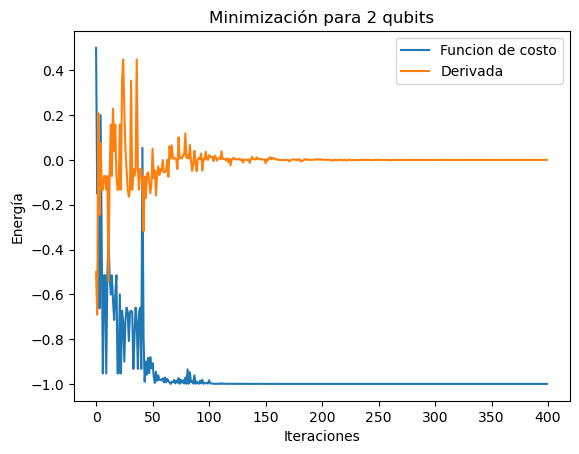

None

Fin ejecución con 2 qubits. Mínimo encontrado: -0.9999999811942089

Preparando ejecución para 3 qubits.
Se usarán 90 parámetros


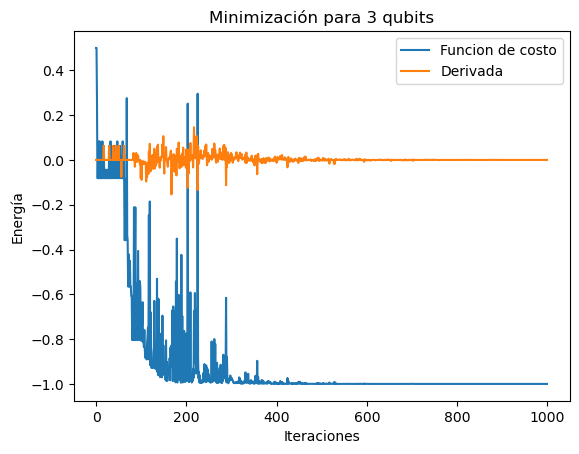

None

Fin ejecución con 3 qubits. Mínimo encontrado: -0.9999999934628836

Preparando ejecución para 4 qubits.
Se usarán 160 parámetros


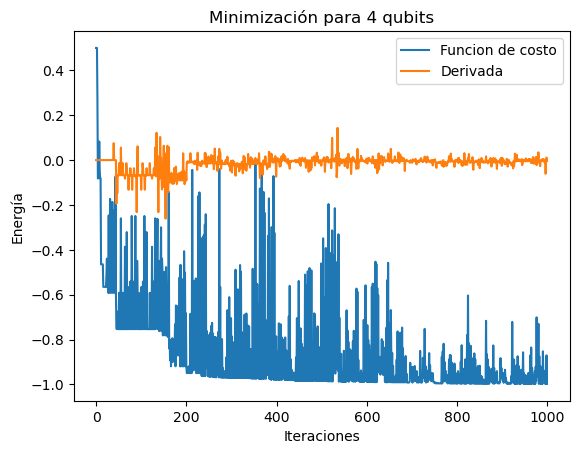

None

Fin ejecución con 4 qubits. Mínimo encontrado: -0.9978954425844675

Preparando ejecución para 5 qubits.
Se usarán 250 parámetros


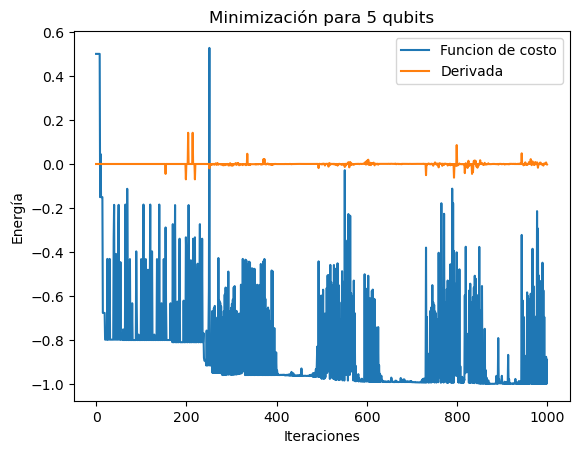

None

Fin ejecución con 5 qubits. Mínimo encontrado: -0.9987858824589283

Preparando ejecución para 6 qubits.
Se usarán 360 parámetros


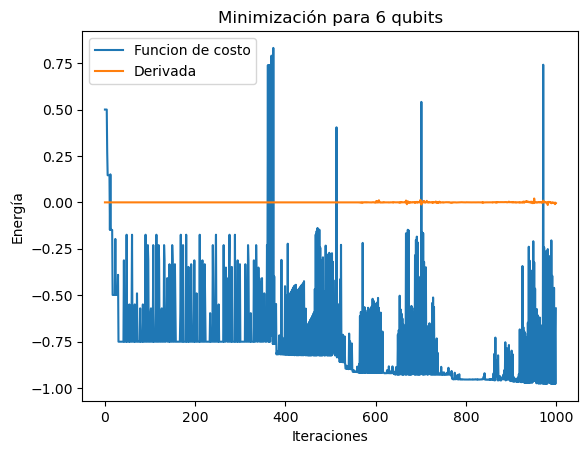

None

Fin ejecución con 6 qubits. Mínimo encontrado: -0.9781530988576415

Preparando ejecución para 7 qubits.
Se usarán 490 parámetros


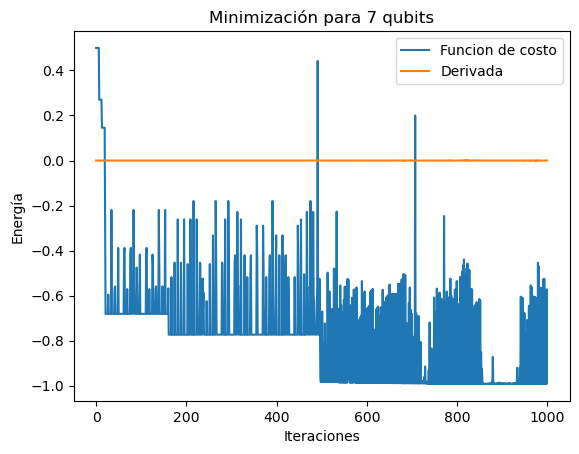

None

Fin ejecución con 7 qubits. Mínimo encontrado: -0.9920700545850197

Preparando ejecución para 8 qubits.
Se usarán 640 parámetros


KeyboardInterrupt: 

In [43]:
# Numero de Qubits a utilizar
max_qubits = 15

# Para derivada
index = 0

# Creamos el estimador para el simulador
estimator = Estimator()

for i in range(2, max_qubits+1):
    
    current_observable=expand_observable(base_observable, i)
    ansatz_circuit, thetas = build_deep_ansatz(i)

    # Parámetros iniciales
    initial_param_vector = np.zeros(len(thetas)*i)

    # Información sobre la iteración actual
    print("\n=====================================================")
    print(f"Preparando ejecución para {i} qubits.")
    print(f"Se usarán {len(thetas)*i} parámetros")

    # Diccionario para almacenar la evolución del costo
    cost_history_dict = {
        "iters": 0,
        "cost_history": [],
        "deriv_history": [],
    }

    def cost_func(params, ansatz, observable, index, estimator):

        cost = evaluate_observable(params, ansatz, observable, estimator)
        deriv = evaluate_deriv(params, ansatz, observable, index, estimator)

        cost_history_dict["iters"] += 1
        cost_history_dict["cost_history"].append(cost)
        cost_history_dict["deriv_history"].append(deriv)

        return cost

    # Ejecutamos la optimización
    res = minimize(
        cost_func,
        initial_param_vector,
        args=(ansatz_circuit, current_observable, index, estimator),
        method="COBYLA",
    )

    # Graficar evolución del costo
    fig, ax = plt.subplots()
    ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label="Funcion de costo")
    ax.plot(range(cost_history_dict["iters"]), cost_history_dict["deriv_history"], label="Derivada")
    ax.set_xlabel("Iteraciones")
    ax.set_ylabel("Energía")
    ax.set_title(f"Minimización para {i} qubits")
    plt.legend()
    display(plt.show())

    print(f"Fin ejecución con {i} qubits. Mínimo encontrado: {res.fun}")
    print("=====================================================")



Calculando varianzas con 2 qubits.

Varianza del valor esperado: 0.21480220112113402
Varianza de la derivada: 0.05957073555450913

Calculando varianzas con 3 qubits.

Varianza del valor esperado: 0.1121760733732543
Varianza de la derivada: 0.03142989180708957

Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.06495976172241576
Varianza de la derivada: 0.029337039963660577

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.034898808120833014
Varianza de la derivada: 0.007629393465056986

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.017132725772584532
Varianza de la derivada: 0.007357143886727508

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.007942200699170373
Varianza de la derivada: 0.0020742330659088595

Calculando varianzas con 8 qubits.

Varianza del valor esperado: 0.004200962052108375
Varianza de la derivada: 0.0019346014056979047

Calculando varianzas con 9 qubits.

Varianza del valor esperado: 0.00258

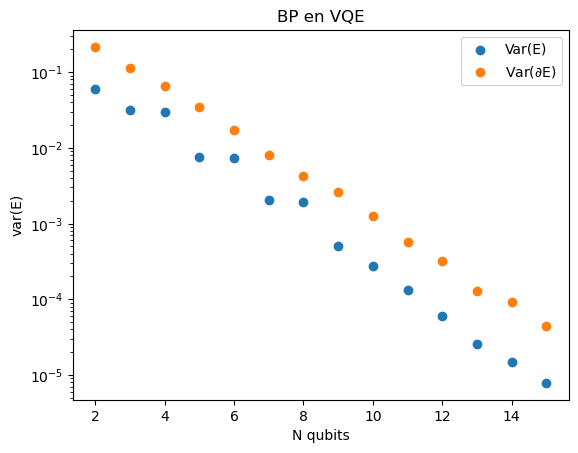

None

In [ ]:
# Cuantos qubits usar
max_qubits = 15

# Cuantos valores de la funcion de costo probar para calcular la varianza
N = 200

# Datos que pintamos al final
data = []

# Bucle número de qubits
for i in range(2, max_qubits+1):

    # Información sobre la iteración actual
    print("\n=====================================================")
    print(f"Calculando varianzas con {i} qubits.\n")
    
    result = get_variances_data(base_observable, i, index=0, num_shots=N)
    print(f"Varianza del valor esperado: {result[0]}")
    print(f"Varianza de la derivada: {result[1]}")

    data.append(result)

data = np.array(data)
# Grafica concentracion del resultado y su derivada
fig, ax = plt.subplots()
ax.scatter(data[:,2], data[:,1], label="Var(E)")
ax.scatter(data[:,2], data[:,0], label=r"Var($\partial$E)")
ax.set_xlabel("N qubits")
ax.set_ylabel("var(E)")
ax.set_title(f"BP en VQE")
ax.set_yscale("log")
ax.legend()
display(plt.show())

### Calculo de la pendiente

Pendiente para valor esperado: -0.6606530422686507.
Pendiente para derivada: -0.7145053603944166.


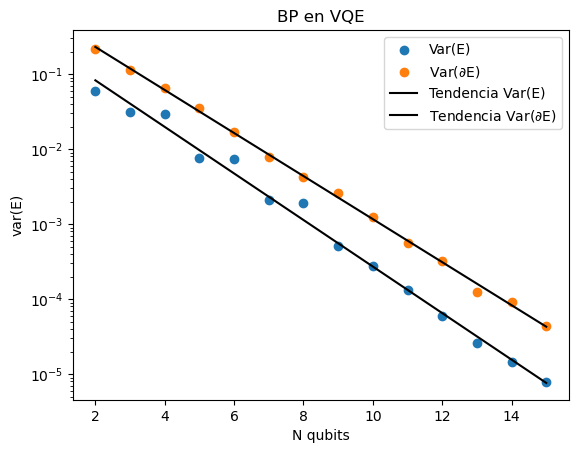

None

In [ ]:
deriv = linregress(data[:,2], np.log(data[:,1]))

value = linregress(data[:,2], np.log(data[:,0]))

print(f"Pendiente para valor esperado: {value[0]}.")
print(f"Pendiente para derivada: {deriv[0]}.")


fig, ax = plt.subplots()
ax.scatter(data[:,2], data[:,1], label="Var(E)")
ax.scatter(data[:,2], data[:,0], label=r"Var($\partial$E)")

base = np.linspace(2, max_qubits, 100)

ax.plot(base, np.exp(value[0]*base+value[1]), color="black", label="Tendencia Var(E)")
ax.plot(base, np.exp(deriv[0]*base+deriv[1]), color="black", label=r"Tendencia Var($\partial$E)")

ax.set_xlabel("N qubits")
ax.set_ylabel("var(E)")
ax.set_title(f"BP en VQE")
ax.set_yscale("log")
ax.legend()
display(plt.show())